In [1]:
# import necessary libraries

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from rdkit import Chem
from rdkit.Chem import AllChem, MACCSkeys, Descriptors
import torch
from torch_geometric.data import Data
import deepchem as dc


c:\Users\asus\anaconda3\envs\chemgpu\lib\site-packages\torch_geometric\__init__.py:4: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  import torch_geometric.typing
c:\Users\asus\anaconda3\envs\chemgpu\lib\site-packages\torch_geometric\__init__.py:4: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  import torch_geometric.typing
c:\Users\asus\anaconda3\envs\chemgpu\lib\site-packages\torch_geometric\__init__.py:4: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  import torch_geometric.typing
c:\Users\asus\anaconda3\envs\chemgpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/

In [2]:
# set random seed for reproducibility

np.random.seed(42)
torch.manual_seed(42)
os.makedirs("tox21_processed", exist_ok=True)

print("Loading Tox21 dataset...")
tasks, datasets, transformers = dc.molnet.load_tox21(featurizer="Raw", data_dir=".", save_dir=".")
train_dataset, valid_dataset, test_dataset = datasets

# convert datasets to pandas DataFrames for easier manipulation
train_df = train_dataset.to_dataframe()
valid_df = valid_dataset.to_dataframe()
test_df = test_dataset.to_dataframe()

# map tasks to column names such as tasks[0] is y1 column, replace it with tasks[0]
for i, task in enumerate(tasks):
    train_df.rename(columns={f'y{i+1}': task}, inplace=True)
    valid_df.rename(columns={f'y{i+1}': task}, inplace=True)
    test_df.rename(columns={f'y{i+1}': task}, inplace=True)

# extract molecular features using RDKit and save to CSV files
def featurize_molecule(smi):
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        return None
    features = {}
    # Basic descriptors
    features['MolWt'] = Descriptors.MolWt(mol)
    features['NumHDonors'] = Descriptors.NumHDonors(mol)
    features['NumHAcceptors'] = Descriptors.NumHAcceptors(mol)
    features['TPSA'] = Descriptors.TPSA(mol)
    features['LogP'] = Descriptors.MolLogP(mol)
    # MACCS keys
    maccs = MACCSkeys.GenMACCSKeys(mol)
    for i in range(167):
        features[f'MACCS_{i}'] = int(maccs.GetBit(i))
    # Morgan fingerprint
    morgan_fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
    for i in range(2048):
        features[f'Morgan_{i}'] = int(morgan_fp.GetBit(i))
    return features

def featurize_dataset(df):
    feature_list = []
    for smi in tqdm(df['ids'], desc="Featurizing molecules"):
        feats = featurize_molecule(smi)
        if feats is not None:
            feature_list.append(feats)
        else:
            feature_list.append({})  # Append empty dict for invalid SMILES
    features_df = pd.DataFrame(feature_list)
    return pd.concat([df.reset_index(drop=True), features_df.reset_index(drop=True)], axis=1)

train_features_df = featurize_dataset(train_df)
valid_features_df = featurize_dataset(valid_df)
test_features_df = featurize_dataset(test_df)

Loading Tox21 dataset...


Featurizing molecules:   0%|          | 0/6258 [00:00<?, ?it/s][20:21:09] DEPRECATION WARNING: please use MorganGenerator
[20:21:09] DEPRECATION WARNING: please use MorganGenerator
[20:21:09] DEPRECATION WARNING: please use MorganGenerator
[20:21:09] DEPRECATION WARNING: please use MorganGenerator
[20:21:09] DEPRECATION WARNING: please use MorganGenerator
[20:21:09] DEPRECATION WARNING: please use MorganGenerator
[20:21:09] DEPRECATION WARNING: please use MorganGenerator
[20:21:09] DEPRECATION WARNING: please use MorganGenerator
[20:21:09] DEPRECATION WARNING: please use MorganGenerator
[20:21:09] DEPRECATION WARNING: please use MorganGenerator
[20:21:09] DEPRECATION WARNING: please use MorganGenerator
[20:21:09] DEPRECATION WARNING: please use MorganGenerator
[20:21:09] DEPRECATION WARNING: please use MorganGenerator
[20:21:09] DEPRECATION WARNING: please use MorganGenerator
[20:21:09] DEPRECATION WARNING: please use MorganGenerator
[20:21:09] DEPRECATION WARNING: please use MorganGen

In [3]:
# check the new dataframes
print("Featurized training set sample:")
train_features_df.head()

Featurized training set sample:


,X,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,...,Morgan_2038,Morgan_2039,Morgan_2040,Morgan_2041,Morgan_2042,Morgan_2043,Morgan_2044,Morgan_2045,Morgan_2046,Morgan_2047
0,<rdkit.Chem.rdchem.Mol object at 0x000001E2D1F...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,<rdkit.Chem.rdchem.Mol object at 0x000001E2D1F...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,<rdkit.Chem.rdchem.Mol object at 0x000001E2D1F...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,<rdkit.Chem.rdchem.Mol object at 0x000001E2D1F...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,<rdkit.Chem.rdchem.Mol object at 0x000001E2D1F...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


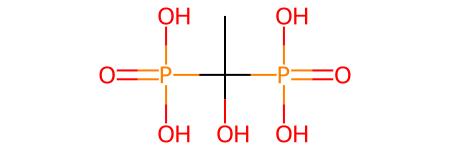

In [4]:
x = train_features_df.head().iloc[0]["X"]
x

In [5]:
from rdkit.Chem.Descriptors import descList
rdkit_featurizer = dc.feat.RDKitDescriptors()
features = rdkit_featurizer(['CCC'])[0]
descriptors = [i[0] for i in descList]
for feature, descriptor in zip(features[:10], descriptors):
    print(descriptor, feature)


MaxAbsEStateIndex 0.9182958340544894
MaxEStateIndex 1.3523744386698802
MinAbsEStateIndex -1.4760582438091696
MinEStateIndex 1.55881365076144
qed -1.2696136507614397
SPS 3.9177136507614425
MolWt 1.089286349238561
HeavyAtomMolWt 13.425713650761436
ExactMolWt 10.597286349238557
NumValenceElectrons 1.6329931618554523


In [6]:
# from deepchem.models import GraphTransformerModel

# model = GraphTransformerModel(
#     len(tasks),              # 12 tasks (multi-task)
#     mode='classification',
#     number_atom_features=78, # default RDKit atom features
#     attention_heads=8,
#     dropout=0.1,
#     encoder_layers=4,
#     embed_dim=128
# )

# model.fit(train_dataset, nb_epoch=30)
# metric = dc.metrics.Metric(dc.metrics.roc_auc_score, mode="classification")

# train_score = model.evaluate(train_dataset, [metric])
# valid_score = model.evaluate(valid_dataset, [metric])
# print("Train ROC-AUC:", train_score, "Valid ROC-AUC:", valid_score)

In [ ]:
from torch_geometric.nn import global_mean_pool
import torch
from torch import nn
import torch.nn.functional as F
import torch_geometric
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, WeightedRandomSampler


def sinusoidal_pos_encoding(pos: torch.Tensor, num_freqs: int = 8) -> torch.Tensor:
    """
    pos: [N, 3] coordinates (Å-ish). Returns [N, 3 * 2 * num_freqs].
    Scales positions by multiple frequencies; sin/cos per axis.
    """
    # center & scale (stable)
    p = pos - pos.mean(dim=0, keepdim=True)
    scale = p.norm(dim=1).mean().clamp(min=1e-6)
    p = p / scale

    freqs = 2.0 ** torch.arange(num_freqs, dtype=pos.dtype, device=pos.device)  # [num_freqs]
    p = p.unsqueeze(-1)  # [N,3,1]
    args = p * freqs  # [N,3,num_freqs]
    sin = torch.sin(args)
    cos = torch.cos(args)
    pe = torch.cat([sin, cos], dim=-1)  # [N,3,2*num_freqs]
    pe = pe.flatten(1)  # [N, 3*2*num_freqs]
    return pe  # concat into node features


class SimpleTransformerConv(nn.Module):
    def __init__(self, in_dim, out_dim, heads=4, edge_dim=None, dropout=0.0):
        super().__init__()
        self.heads = heads
        self.out_dim = out_dim
        self.dk = out_dim // heads

        self.W_q = nn.Linear(in_dim, out_dim)
        self.W_k = nn.Linear(in_dim, out_dim)
        self.W_v = nn.Linear(in_dim, out_dim)
        if edge_dim is not None:
            self.W_e = nn.Linear(edge_dim, heads)
        else:
            self.W_e = None

        self.out_proj = nn.Linear(out_dim, out_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index, edge_attr=None):
        # x: [num_nodes, in_dim]
        # edge_index: [2, num_edges]
        num_nodes = x.size(0)

        # Project into multi-head Q, K, V
        Q = self.W_q(x).view(num_nodes, self.heads, self.dk)
        K = self.W_k(x).view(num_nodes, self.heads, self.dk)
        V = self.W_v(x).view(num_nodes, self.heads, self.dk)

        # Build edge list
        src, dst = edge_index  # edges j -> i
        q_i = Q[dst]           # [E, heads, dk]
        k_j = K[src]
        v_j = V[src]

        # Attention scores
        attn_scores = (q_i * k_j).sum(dim=-1) / (self.dk ** 0.5)

        # Add edge bias (optional)
        if self.W_e is not None and edge_attr is not None:
            edge_bias = self.W_e(edge_attr)  # [E, heads]
            attn_scores = attn_scores + edge_bias

        # Softmax over neighbors of each node
        attn_scores = torch_geometric.utils.softmax(attn_scores, dst)

        # Apply dropout to attention
        attn_scores = self.dropout(attn_scores)

        # Weighted sum of neighbor values
        out = v_j * attn_scores.unsqueeze(-1)
        out = torch.zeros_like(Q).index_add_(0, dst, out)  # aggregate to dst nodes

        # Merge heads
        out = out.view(num_nodes, -1)
        out = self.out_proj(out)
        return out
    
class MoleculeTransformer(nn.Module):
    def __init__(self, in_dim, hidden_dim, num_tasks, heads=4):
        super().__init__()
        self.layer1 = SimpleTransformerConv(in_dim, hidden_dim, heads=heads)
        self.layer2 = SimpleTransformerConv(hidden_dim, hidden_dim, heads=heads)
        self.lin = nn.Linear(hidden_dim, num_tasks)

    def forward(self, data):
        x, edge_index, batch, edge_attr= data.x, data.edge_index, data.batch, data.edge_attr
        
        x = F.relu(self.layer1(x, edge_index, edge_attr))
        x = F.relu(self.layer2(x, edge_index, edge_attr))
        x = global_mean_pool(x, batch)
        return torch.sigmoid(self.lin(x))

In [8]:
import torch

from torch_geometric.data import Data
# --- Your model classes (paste here) ---
# SimpleTransformerConv
# MoleculeTransformer

# --- Random synthetic graph batch ---
# Can be any thing
num_nodes = 20
num_edges = 60


# Must be Fixed
node_dim = 10
edge_dim = 5
num_tasks = 12

hidden_dim = 32
heads = 4

# Random node features and edges
x = torch.randn(num_nodes, node_dim)
edge_index = torch.randint(0, num_nodes, (2, num_edges))
edge_attr = torch.randn(num_edges, edge_dim)

# Assign every node to one of 3 graphs
batch = torch.randint(0, 3, (num_nodes,))

# --- Initialize model ---
model = MoleculeTransformer(in_dim=node_dim,
                            hidden_dim=hidden_dim,
                            num_tasks=num_tasks,
                            heads=heads)

data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
# --- Forward pass ---
out = model(data)

print("Output shape:", out.shape)   # expected: [num_graphs, num_tasks]
print("Example output:\n", out[:2])


Output shape: torch.Size([1, 12])
Example output:
 tensor([[0.4683, 0.4526, 0.5433, 0.4799, 0.5277, 0.4422, 0.5207, 0.5486, 0.4913,
         0.4740, 0.5131, 0.4923]], grad_fn=<SliceBackward0>)


In [9]:
train_graphs = torch.load("tox21_processed/train_graphs.pt")
valid_graphs = torch.load("tox21_processed/valid_graphs.pt")
test_graphs = torch.load("tox21_processed/test_graphs.pt")

C:\Users\asus\AppData\Local\Temp\ipykernel_22608\3270152255.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_graphs = torch.load("tox21_processed/train_graphs.pt")


In [10]:
import deepchem as dc
input_dim = train_graphs[0].x.shape[1]
hidden_dim = 64
output_dim = train_graphs[0].y.shape[0]
gnn_model = MoleculeTransformer(input_dim, hidden_dim, output_dim)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(gnn_model.parameters(), lr=0.001)
# prepare data loaders
from torch_geometric.loader import DataLoader
train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_graphs, batch_size=32, shuffle=False)
test_loader = DataLoader(test_graphs, batch_size=32, shuffle=False)
# train the GNN
num_epochs = 20
for epoch in range(num_epochs):
    gnn_model.train()
    total_loss = 0
    for batch_idx ,data in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = gnn_model(data)
        # reshape data.y to [batch_size, num_tasks]
        y = data.y.view(outputs.shape)
        # Clamp y to [0, 1] to avoid BCELoss error
        # y = torch.clamp(y, 0, 1)
        # y = torch.nan_to_num(y, nan=1)
        mask = ~torch.isnan(y)  
        loss = criterion(outputs[mask], y[mask])
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    avg_loss = total_loss / len(train_loader.dataset)
    if (epoch+1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score

y_gnn_pred_list, y_gnn_true_list, valid_mask_list = [], [], []

gnn_model.eval()
with torch.no_grad():
    for data in test_loader:
        outputs = gnn_model(data).cpu()  # (num_graphs_in_batch, output_dim)
        y = data.y.cpu().float()

        # --- reshape y per graph ---
        y = y.view(data.num_graphs, -1)

        # --- align lengths ---
        pad_len = outputs.shape[1] - y.shape[1]
        if pad_len > 0:
            y = torch.cat([y, torch.full((y.shape[0], pad_len), float('nan'))], dim=1)
        elif pad_len < 0:
            outputs = torch.cat([outputs, torch.zeros((outputs.shape[0], -pad_len))], dim=1)

        mask = ~torch.isnan(y)
        y = torch.nan_to_num(y, nan=0.0)

        y_gnn_true_list.append(y)
        y_gnn_pred_list.append(outputs)
        valid_mask_list.append(mask)

# --- concatenate across batches ---
y_gnn_true = torch.cat(y_gnn_true_list, dim=0)
y_gnn_pred = torch.cat(y_gnn_pred_list, dim=0)
valid_mask = torch.cat(valid_mask_list, dim=0)

# --- convert to numpy ---
y_true_np = y_gnn_true.numpy()
y_pred_np = y_gnn_pred.numpy()
mask_np = valid_mask.numpy()

# --- apply threshold ---
y_pred_bin = (y_pred_np > 0.5).astype(int)

# --- classification report ---
print("GNN Classification report on test set:")
valid_idx = mask_np.sum(axis=0) > 0
print(classification_report(
    y_true_np[:, valid_idx],
    y_pred_bin[:, valid_idx],
    zero_division=0
))

# --- ROC-AUC per task ---
tasks, _, _ = dc.molnet.load_tox21(featurizer="Raw", data_dir=".", save_dir=".")
for i, task in enumerate(tasks[:y_true_np.shape[1]]):
    if mask_np[:, i].sum() == 0:
        print(f"ROC AUC for task {task}: Skipped (no valid samples)")
        continue
    try:
        auc = roc_auc_score(
            y_true_np[mask_np[:, i], i],
            y_pred_np[mask_np[:, i], i]
        )
        print(f"ROC AUC for task {task}: {auc:.4f}")
    except ValueError:
        print(f"ROC AUC for task {task}: Cannot be computed (only one class present in y_true)")

Epoch [5/20], Loss: 0.1987
Epoch [10/20], Loss: 0.1925
Epoch [15/20], Loss: 0.1883
Epoch [20/20], Loss: 0.1838
GNN Classification report on test set:
              precision    recall  f1-score   support

           0       0.37      0.29      0.33        24
           1       0.29      0.31      0.30        16
           2       0.47      0.10      0.17        90
           3       0.00      0.00      0.00        46
           4       0.00      0.00      0.00        62
           5       0.00      0.00      0.00        18
           6       0.00      0.00      0.00        20
           7       0.43      0.03      0.05       111
           8       0.00      0.00      0.00        31
           9       0.00      0.00      0.00        44
          10       0.28      0.15      0.19        89
          11       0.00      0.00      0.00        65

   micro avg       0.34      0.06      0.10       616
   macro avg       0.15      0.07      0.09       616
weighted avg       0.21      0.06     

In [11]:
train_graphs =torch.load("tox21_processed/strat_train_graphs.pt")
valid_graphs =torch.load("tox21_processed/strat_valid_graphs.pt")
test_graphs =torch.load("tox21_processed/strat_test_graphs.pt")

C:\Users\asus\AppData\Local\Temp\ipykernel_22608\610043236.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_graphs =torch.load("tox21_processed/strat_train_graphs.p

In [12]:
import deepchem as dc
input_dim = train_graphs[0].x.shape[1]
hidden_dim = 64
output_dim = train_graphs[0].y.shape[0]
gnn_model = MoleculeTransformer(input_dim, hidden_dim, output_dim)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(gnn_model.parameters(), lr=0.001)
# prepare data loaders
from torch_geometric.loader import DataLoader
train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_graphs, batch_size=32, shuffle=False)
test_loader = DataLoader(test_graphs, batch_size=32, shuffle=False)
# train the GNN
num_epochs = 20
for epoch in range(num_epochs):
    gnn_model.train()
    total_loss = 0
    for batch_idx ,data in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = gnn_model(data)
        # reshape data.y to [batch_size, num_tasks]
        y = data.y.view(outputs.shape)
        # Clamp y to [0, 1] to avoid BCELoss error
        # y = torch.clamp(y, 0, 1)
        # y = torch.nan_to_num(y, nan=1)
        mask = ~torch.isnan(y)  
        loss = criterion(outputs[mask], y[mask])
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    avg_loss = total_loss / len(train_loader.dataset)
    if (epoch+1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score

y_gnn_pred_list, y_gnn_true_list, valid_mask_list = [], [], []

gnn_model.eval()
with torch.no_grad():
    for data in test_loader:
        outputs = gnn_model(data).cpu()  # (num_graphs_in_batch, output_dim)
        y = data.y.cpu().float()

        # --- reshape y per graph ---
        y = y.view(data.num_graphs, -1)

        # --- align lengths ---
        pad_len = outputs.shape[1] - y.shape[1]
        if pad_len > 0:
            y = torch.cat([y, torch.full((y.shape[0], pad_len), float('nan'))], dim=1)
        elif pad_len < 0:
            outputs = torch.cat([outputs, torch.zeros((outputs.shape[0], -pad_len))], dim=1)

        mask = ~torch.isnan(y)
        y = torch.nan_to_num(y, nan=0.0)

        y_gnn_true_list.append(y)
        y_gnn_pred_list.append(outputs)
        valid_mask_list.append(mask)

# --- concatenate across batches ---
y_gnn_true = torch.cat(y_gnn_true_list, dim=0)
y_gnn_pred = torch.cat(y_gnn_pred_list, dim=0)
valid_mask = torch.cat(valid_mask_list, dim=0)

# --- convert to numpy ---
y_true_np = y_gnn_true.numpy()
y_pred_np = y_gnn_pred.numpy()
mask_np = valid_mask.numpy()

# --- apply threshold ---
y_pred_bin = (y_pred_np > 0.5).astype(int)

# --- classification report ---
print("GNN Classification report on test set:")
valid_idx = mask_np.sum(axis=0) > 0
print(classification_report(
    y_true_np[:, valid_idx],
    y_pred_bin[:, valid_idx],
    zero_division=0
))

# --- ROC-AUC per task ---
tasks, _, _ = dc.molnet.load_tox21(featurizer="Raw", data_dir=".", save_dir=".")
for i, task in enumerate(tasks[:y_true_np.shape[1]]):
    if mask_np[:, i].sum() == 0:
        print(f"ROC AUC for task {task}: Skipped (no valid samples)")
        continue
    try:
        auc = roc_auc_score(
            y_true_np[mask_np[:, i], i],
            y_pred_np[mask_np[:, i], i]
        )
        print(f"ROC AUC for task {task}: {auc:.4f}")
    except ValueError:
        print(f"ROC AUC for task {task}: Cannot be computed (only one class present in y_true)")

Epoch [5/20], Loss: 0.2190
Epoch [10/20], Loss: 0.2128
Epoch [15/20], Loss: 0.2084
Epoch [20/20], Loss: 0.2033
GNN Classification report on test set:
              precision    recall  f1-score   support

           0       0.67      0.33      0.44        24
           1       0.45      0.31      0.37        16
           2       0.45      0.06      0.10        90
           3       0.00      0.00      0.00        46
           4       0.33      0.02      0.03        62
           5       0.00      0.00      0.00        18
           6       0.00      0.00      0.00        20
           7       0.00      0.00      0.00       111
           8       0.00      0.00      0.00        31
           9       0.00      0.00      0.00        44
          10       0.00      0.00      0.00        89
          11       0.00      0.00      0.00        65

   micro avg       0.46      0.03      0.06       616
   macro avg       0.16      0.06      0.08       616
weighted avg       0.14      0.03     

In [13]:
train_graphs =torch.load("tox21_processed/bal_train_graphs.pt")
valid_graphs =torch.load("tox21_processed/bal_valid_graphs.pt")
test_graphs =torch.load("tox21_processed/bal_test_graphs.pt")


C:\Users\asus\AppData\Local\Temp\ipykernel_22608\1015858886.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_graphs =torch.load("tox21_processed/bal_train_graphs.pt

In [14]:
import deepchem as dc
input_dim = train_graphs[0].x.shape[1]
hidden_dim = 64
output_dim = train_graphs[0].y.shape[0]
gnn_model = MoleculeTransformer(input_dim, hidden_dim, output_dim)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(gnn_model.parameters(), lr=0.001)
# prepare data loaders
from torch_geometric.loader import DataLoader
train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_graphs, batch_size=32, shuffle=False)
test_loader = DataLoader(test_graphs, batch_size=32, shuffle=False)
# train the GNN
num_epochs = 20
for epoch in range(num_epochs):
    gnn_model.train()
    total_loss = 0
    for batch_idx ,data in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = gnn_model(data)
        # reshape data.y to [batch_size, num_tasks]
        y = data.y.view(outputs.shape)
        # Clamp y to [0, 1] to avoid BCELoss error
        # y = torch.clamp(y, 0, 1)
        # y = torch.nan_to_num(y, nan=1)
        mask = ~torch.isnan(y)  
        loss = criterion(outputs[mask], y[mask])
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    avg_loss = total_loss / len(train_loader.dataset)
    if (epoch+1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score

y_gnn_pred_list, y_gnn_true_list, valid_mask_list = [], [], []

gnn_model.eval()
with torch.no_grad():
    for data in test_loader:
        outputs = gnn_model(data).cpu()  # (num_graphs_in_batch, output_dim)
        y = data.y.cpu().float()

        # --- reshape y per graph ---
        y = y.view(data.num_graphs, -1)

        # --- align lengths ---
        pad_len = outputs.shape[1] - y.shape[1]
        if pad_len > 0:
            y = torch.cat([y, torch.full((y.shape[0], pad_len), float('nan'))], dim=1)
        elif pad_len < 0:
            outputs = torch.cat([outputs, torch.zeros((outputs.shape[0], -pad_len))], dim=1)

        mask = ~torch.isnan(y)
        y = torch.nan_to_num(y, nan=0.0)

        y_gnn_true_list.append(y)
        y_gnn_pred_list.append(outputs)
        valid_mask_list.append(mask)

# --- concatenate across batches ---
y_gnn_true = torch.cat(y_gnn_true_list, dim=0)
y_gnn_pred = torch.cat(y_gnn_pred_list, dim=0)
valid_mask = torch.cat(valid_mask_list, dim=0)

# --- convert to numpy ---
y_true_np = y_gnn_true.numpy()
y_pred_np = y_gnn_pred.numpy()
mask_np = valid_mask.numpy()

# --- apply threshold ---
y_pred_bin = (y_pred_np > 0.5).astype(int)

# --- classification report ---
print("GNN Classification report on test set:")
valid_idx = mask_np.sum(axis=0) > 0
print(classification_report(
    y_true_np[:, valid_idx],
    y_pred_bin[:, valid_idx],
    zero_division=0
))

# --- ROC-AUC per task ---
tasks, _, _ = dc.molnet.load_tox21(featurizer="Raw", data_dir=".", save_dir=".")
for i, task in enumerate(tasks[:y_true_np.shape[1]]):
    if mask_np[:, i].sum() == 0:
        print(f"ROC AUC for task {task}: Skipped (no valid samples)")
        continue
    try:
        auc = roc_auc_score(
            y_true_np[mask_np[:, i], i],
            y_pred_np[mask_np[:, i], i]
        )
        print(f"ROC AUC for task {task}: {auc:.4f}")
    except ValueError:
        print(f"ROC AUC for task {task}: Cannot be computed (only one class present in y_true)")

Epoch [5/20], Loss: 0.2187
Epoch [10/20], Loss: 0.2118
Epoch [15/20], Loss: 0.2072
Epoch [20/20], Loss: 0.2047
GNN Classification report on test set:
              precision    recall  f1-score   support

           0       0.62      0.21      0.31        24
           1       0.33      0.06      0.11        16
           2       0.75      0.07      0.12        90
           3       0.00      0.00      0.00        46
           4       0.00      0.00      0.00        62
           5       0.00      0.00      0.00        18
           6       0.00      0.00      0.00        20
           7       0.00      0.00      0.00       111
           8       0.00      0.00      0.00        31
           9       0.00      0.00      0.00        44
          10       0.50      0.01      0.02        89
          11       0.00      0.00      0.00        65

   micro avg       0.62      0.02      0.04       616
   macro avg       0.18      0.03      0.05       616
weighted avg       0.21      0.02     

In [15]:
train_graphs =torch.load("tox21_processed/rare_train_graphs.pt")
valid_graphs =torch.load("tox21_processed/rare_valid_graphs.pt")
test_graphs =torch.load("tox21_processed/rare_test_graphs.pt")

C:\Users\asus\AppData\Local\Temp\ipykernel_22608\3106762886.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_graphs =torch.load("tox21_processed/rare_train_graphs.p

In [16]:
import deepchem as dc
input_dim = train_graphs[0].x.shape[1]
hidden_dim = 64
output_dim = train_graphs[0].y.shape[0]
gnn_model = MoleculeTransformer(input_dim, hidden_dim, output_dim)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(gnn_model.parameters(), lr=0.001)
# prepare data loaders
from torch_geometric.loader import DataLoader
train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_graphs, batch_size=32, shuffle=False)
test_loader = DataLoader(test_graphs, batch_size=32, shuffle=False)
# train the GNN
num_epochs = 20
for epoch in range(num_epochs):
    gnn_model.train()
    total_loss = 0
    for batch_idx ,data in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = gnn_model(data)
        # reshape data.y to [batch_size, num_tasks]
        y = data.y.view(outputs.shape)
        # Clamp y to [0, 1] to avoid BCELoss error
        # y = torch.clamp(y, 0, 1)
        # y = torch.nan_to_num(y, nan=1)
        mask = ~torch.isnan(y)  
        loss = criterion(outputs[mask], y[mask])
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    avg_loss = total_loss / len(train_loader.dataset)
    if (epoch+1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score

y_gnn_pred_list, y_gnn_true_list, valid_mask_list = [], [], []

gnn_model.eval()
with torch.no_grad():
    for data in test_loader:
        outputs = gnn_model(data).cpu()  # (num_graphs_in_batch, output_dim)
        y = data.y.cpu().float()

        # --- reshape y per graph ---
        y = y.view(data.num_graphs, -1)

        # --- align lengths ---
        pad_len = outputs.shape[1] - y.shape[1]
        if pad_len > 0:
            y = torch.cat([y, torch.full((y.shape[0], pad_len), float('nan'))], dim=1)
        elif pad_len < 0:
            outputs = torch.cat([outputs, torch.zeros((outputs.shape[0], -pad_len))], dim=1)

        mask = ~torch.isnan(y)
        y = torch.nan_to_num(y, nan=0.0)

        y_gnn_true_list.append(y)
        y_gnn_pred_list.append(outputs)
        valid_mask_list.append(mask)

# --- concatenate across batches ---
y_gnn_true = torch.cat(y_gnn_true_list, dim=0)
y_gnn_pred = torch.cat(y_gnn_pred_list, dim=0)
valid_mask = torch.cat(valid_mask_list, dim=0)

# --- convert to numpy ---
y_true_np = y_gnn_true.numpy()
y_pred_np = y_gnn_pred.numpy()
mask_np = valid_mask.numpy()

# --- apply threshold ---
y_pred_bin = (y_pred_np > 0.5).astype(int)

# --- classification report ---
print("GNN Classification report on test set:")
valid_idx = mask_np.sum(axis=0) > 0
print(classification_report(
    y_true_np[:, valid_idx],
    y_pred_bin[:, valid_idx],
    zero_division=0
))

# --- ROC-AUC per task ---
tasks, _, _ = dc.molnet.load_tox21(featurizer="Raw", data_dir=".", save_dir=".")
for i, task in enumerate(tasks[:y_true_np.shape[1]]):
    if mask_np[:, i].sum() == 0:
        print(f"ROC AUC for task {task}: Skipped (no valid samples)")
        continue
    try:
        auc = roc_auc_score(
            y_true_np[mask_np[:, i], i],
            y_pred_np[mask_np[:, i], i]
        )
        print(f"ROC AUC for task {task}: {auc:.4f}")
    except ValueError:
        print(f"ROC AUC for task {task}: Cannot be computed (only one class present in y_true)")

Epoch [5/20], Loss: 0.2389
Epoch [10/20], Loss: 0.2317
Epoch [15/20], Loss: 0.2263
Epoch [20/20], Loss: 0.2228
GNN Classification report on test set:
              precision    recall  f1-score   support

           0       0.50      0.08      0.14        24
           1       0.50      0.06      0.11        16
           2       0.57      0.04      0.08        90
           3       0.00      0.00      0.00        46
           4       0.00      0.00      0.00        62
           5       0.00      0.00      0.00        18
           6       0.00      0.00      0.00        20
           7       0.00      0.00      0.00       111
           8       0.00      0.00      0.00        31
           9       0.00      0.00      0.00        44
          10       0.33      0.03      0.06        89
          11       0.00      0.00      0.00        65

   micro avg       0.45      0.02      0.03       616
   macro avg       0.16      0.02      0.03       616
weighted avg       0.16      0.02     

# ASSAY conditional on clip

In [1]:
import pandas as pd
from torch_geometric.nn import global_mean_pool
import torch
from torch import nn
import torch.nn.functional as F
import torch_geometric
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, WeightedRandomSampler
from torch.utils.data import Dataset
import math
from torch_geometric.loader import DataLoader
# import necessary libraries

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from rdkit import Chem
from rdkit.Chem import AllChem, MACCSkeys, Descriptors
import torch
from torch_geometric.data import Data
import deepchem as dc


train_df = pd.read_csv("tox21_processed/strat_normalized_train_df.csv")
valid_df = pd.read_csv("tox21_processed/strat_normalized_valid_df.csv")
test_df  = pd.read_csv("tox21_processed/strat_normalized_test_df.csv")


c:\Users\asus\anaconda3\envs\chemgpu\lib\site-packages\torch_geometric\__init__.py:4: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: Could not load this library: C:\Users\asus\anaconda3\envs\chemgpu\Lib\site-packages\torch_scatter\_version_cuda.pyd
  import torch_geometric.typing
c:\Users\asus\anaconda3\envs\chemgpu\lib\site-packages\torch_geometric\__init__.py:4: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: Could not load this library: C:\Users\asus\anaconda3\envs\chemgpu\Lib\site-packages\torch_cluster\_version_cuda.pyd
  import torch_geometric.typing
c:\Users\asus\anaconda3\envs\chemgpu\lib\site-packages\torch_geometric\__init__.py:4: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: Could not load this library: C:\Users\asus\anaconda3\envs\chemgpu\Lib\site-packages\torch_spline_conv\_version_cuda.pyd
  import torch_geometric.typing

In [39]:

ASSAY_DESCRIPTIONS = {
    "NR-AR": "Androgen receptor activation assay for endocrine disruption.",
    "NR-AR-LBD": "Assay for ligand binding to the androgen receptor’s ligand-binding domain.",
    "NR-AhR": "Aryl hydrocarbon receptor activation assay detecting xenobiotic signaling.",
    "NR-Aromatase": "Aromatase enzyme inhibition assay for estrogen synthesis interference.",
    "NR-ER": "Estrogen receptor activation assay for endocrine modulation.",
    "NR-ER-LBD": "Ligand-binding domain assay for estrogen receptor activation/inhibition.",
    "NR-PPAR-gamma": "Peroxisome proliferator-activated receptor gamma activation assay for metabolic regulation.",
    "SR-ARE": "Antioxidant response element reporter assay for oxidative stress response.",
    "SR-ATAD5": "ATAD5-luciferase reporter assay for DNA damage and genomic stress.",
    "SR-HSE": "Heat shock element activation assay for protein misfolding stress response.",
    "SR-MMP": "Mitochondrial membrane potential assay measuring mitochondrial dysfunction.",
    "SR-p53": "p53 reporter assay for genotoxic and stress-induced DNA damage response."
}
TASKS= list(ASSAY_DESCRIPTIONS.keys())  # fixed 1
def sinusoidal_pos_encoding_1d(num_nodes: int, dim: int = 32) -> torch.Tensor:
    """
    Standard Transformer sinusoidal positional encoding for atom order.
    Returns [num_nodes, dim].
    """
    position = torch.arange(num_nodes, dtype=torch.float).unsqueeze(1)  # [N,1]
    div_term = torch.exp(torch.arange(0, dim, 2).float() * (-math.log(10000.0) / dim))
    pe = torch.zeros(num_nodes, dim)
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe

def mol_to_graph_data_obj(mol: Chem.Mol, y_row: torch.Tensor) -> Data:
    if mol is None:
        return None

    # node features (basic chem)
    atom_feats = []
    for atom in mol.GetAtoms():
        atom_feats.append([
            atom.GetAtomicNum(),
            atom.GetDegree(),
            atom.GetFormalCharge(),
            int(atom.GetHybridization()),      # keep numeric enum
            int(atom.GetIsAromatic()),
        ])

    pos_emb = sinusoidal_pos_encoding_1d(len(atom_feats), dim=32)
    x = torch.tensor(atom_feats, dtype=torch.float)  # [N,5]
    x = torch.cat([x, pos_emb], dim=1)  # [N, 5+32]

    # edges
    edge_index, edge_attr = [], []
    for b in mol.GetBonds():
        i, j = b.GetBeginAtomIdx(), b.GetEndAtomIdx()
        edge_index += [(i, j), (j, i)]
        bt = b.GetBondType()
        onehot = [
            int(bt == Chem.rdchem.BondType.SINGLE),
            int(bt == Chem.rdchem.BondType.DOUBLE),
            int(bt == Chem.rdchem.BondType.TRIPLE),
        ]
        edge_attr += [onehot, onehot]
    if edge_index:
        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
        edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    else:
        edge_index = torch.empty((2, 0), dtype=torch.long)
        edge_attr = torch.empty((0, 3), dtype=torch.float)

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y_row.float())
    return data

def build_graph_list_from_df(df, tasks=TASKS):
    """
    df columns: 'ids' (SMILES) + the 12 task columns as 0/1/NaN
    returns: List[Data] with .y = [12]
    """
    graphs = []
    for smi, row in zip(df['ids'].tolist(), df[tasks].values):
        mol = Chem.MolFromSmiles(smi)
        if mol is None:
            continue
        y_row = torch.tensor([0. if (x != 1) else 1. for x in row], dtype=torch.float)  # NaN -> 0
        g = mol_to_graph_data_obj(mol, y_row)
        if g is not None:
            g.smiles = smi
            graphs.append(g)
    return graphs

In [40]:

def multi_positive_clip_loss(graph_emb: torch.Tensor, text_emb_12: torch.Tensor, y_multi_hot: torch.Tensor, tau: float = 0.07):
    """
    graph_emb: [B, D]
    text_emb_12: [12, D] (fixed per step)
    y_multi_hot: [B, 12] in {0,1}
    """
    sim = (graph_emb @ text_emb_12.t()) / tau       # [B,12]
    sim_exp = torch.exp(sim)

    # numerator: sum over all true positives per sample
    pos_sum = (sim_exp * y_multi_hot).sum(dim=1)    # [B]
    # denominator: sum over all 12 texts
    den_sum = sim_exp.sum(dim=1)                    # [B]

    # avoid log(0)
    loss = -torch.log((pos_sum + 1e-8) / (den_sum + 1e-8))
    # if a row has no positives (all zeros), skip it
    valid = (y_multi_hot.sum(dim=1) > 0).float()
    loss = (loss * valid).sum() / (valid.sum().clamp(min=1.0))
    return loss

class MoleculeAssayPairDataset(Dataset):
    def __init__(self, graphs):  # each Data has .y : [12]
        self.graphs = graphs

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        return self.graphs[idx]

def make_balanced_sampler(graphs):
    # weight per sample = inverse(#positives+0.5) to upweight rare-positive rows
    y = torch.stack([g.y for g in graphs])  # [N,12]
    pos_counts = y.sum(dim=1)               # [N]
    weights = 1.0 / (pos_counts + 0.5)      # tune 0.5 if needed
    weights = weights / weights.mean()
    return WeightedRandomSampler(weights.tolist(), num_samples=len(weights), replacement=True)

class TextBank(nn.Module):
    def __init__(self, assay2text, model_name="dmis-lab/biobert-base-cased-v1.1", proj_dim=256, device="cuda"):
        super().__init__()
        self.device = device
        self.assays = list(assay2text.keys())
        self.texts = [assay2text[k] for k in self.assays]
        self.tok = AutoTokenizer.from_pretrained(model_name)
        self.bert = AutoModel.from_pretrained(model_name).to(device)
        for p in self.bert.parameters():  # freeze
            p.requires_grad = False
        self.proj = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, proj_dim),
            nn.ReLU(inplace=True),
            nn.Linear(proj_dim, proj_dim)
        ).to(device)

        with torch.no_grad():
            self.register_buffer("emb", self.encode_all_texts(), persistent=False)  # [12, H]

    @torch.no_grad()
    def encode_all_texts(self):
        embeddings = []
        for text in self.texts:              # iterate each assay individually
            inputs = self.tok(text, return_tensors="pt", truncation=True, padding=True, max_length=64).to(self.device)
            outputs = self.bert(**inputs)
            cls_emb = outputs.last_hidden_state[:, 0, :]  # [1, hidden]
            embeddings.append(cls_emb)
        out = torch.cat(embeddings, dim=0)   # [12, hidden]
        return out

    def forward(self):
        # project + normalize
        t = self.proj(self.emb)            # [12, D]
        return F.normalize(t, dim=-1), self.assays




class SimpleTransformerConv(nn.Module):
    def __init__(self, in_dim, out_dim, heads=4, edge_dim=None, dropout=0.0):
        super().__init__()
        self.heads = heads
        self.out_dim = out_dim
        self.dk = out_dim // heads

        self.W_q = nn.Linear(in_dim, out_dim)
        self.W_k = nn.Linear(in_dim, out_dim)
        self.W_v = nn.Linear(in_dim, out_dim)
        if edge_dim is not None:
            self.W_e = nn.Linear(edge_dim, heads)
        else:
            self.W_e = None

        self.out_proj = nn.Linear(out_dim, out_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index, edge_attr=None):
        # x: [num_nodes, in_dim]
        # edge_index: [2, num_edges]
        num_nodes = x.size(0)

        # Project into multi-head Q, K, V
        Q = self.W_q(x).view(num_nodes, self.heads, self.dk)
        K = self.W_k(x).view(num_nodes, self.heads, self.dk)
        V = self.W_v(x).view(num_nodes, self.heads, self.dk)

        # Build edge list
        src, dst = edge_index  # edges j -> i
        q_i = Q[dst]           # [E, heads, dk]
        k_j = K[src]
        v_j = V[src]

        # Attention scores
        attn_scores = (q_i * k_j).sum(dim=-1) / (self.dk ** 0.5)

        # Add edge bias (optional)
        if self.W_e is not None and edge_attr is not None:
            edge_bias = self.W_e(edge_attr)  # [E, heads]
            attn_scores = attn_scores + edge_bias

        # Softmax over neighbors of each node
        attn_scores = torch_geometric.utils.softmax(attn_scores, dst)

        # Apply dropout to attention
        attn_scores = self.dropout(attn_scores)

        # Weighted sum of neighbor values
        out = v_j * attn_scores.unsqueeze(-1)
        out = torch.zeros_like(Q).index_add_(0, dst, out)  # aggregate to dst nodes

        # Merge heads
        out = out.view(num_nodes, -1)
        out = self.out_proj(out)
        return out
    
class GraphEncoder(nn.Module):
    def __init__(self, in_dim, hidden_dim=256, heads=4, proj_dim=256, edge_dim=3, num_tasks=12):
        super().__init__()
        self.g1 = SimpleTransformerConv(in_dim, hidden_dim, heads=heads, edge_dim=edge_dim, dropout=0.1)
        self.g2 = SimpleTransformerConv(hidden_dim, hidden_dim, heads=heads, edge_dim=edge_dim, dropout=0.1)
        self.proj = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(inplace=True),
            nn.LayerNorm(hidden_dim)
        )
        self.ln1 = nn.LayerNorm(hidden_dim)
        self.ln2 = nn.LayerNorm(hidden_dim)
        # Task classifier head
        self.classifier = nn.Linear(hidden_dim, num_tasks)

    def forward(self, data: Data):
        x = F.relu(self.g1(data.x, data.edge_index, data.edge_attr))
        x  =self.ln1(x)
        x = F.relu(self.g2(x, data.edge_index, data.edge_attr))
        x  =self.ln2(x)
        g = global_mean_pool(x, data.batch)  # [B, hidden_dim]
        g = F.normalize(self.proj(g), dim=-1)
        # Task prediction for BCE
        probs_logits = self.classifier(g) # [B, 12]
        return g , probs_logits# graph embedding [B, D]

In [41]:
# --- build data ---
train_graphs = build_graph_list_from_df(train_df, TASKS)
valid_graphs = build_graph_list_from_df(valid_df, TASKS)

train_set = MoleculeAssayPairDataset(train_graphs)
valid_set = MoleculeAssayPairDataset(valid_graphs)

sampler = make_balanced_sampler(train_graphs)
train_loader = DataLoader(train_set, batch_size=32, sampler=sampler)   # PyG DataLoader
valid_loader = DataLoader(valid_set, batch_size=64, shuffle=False)


device = "cuda" if torch.cuda.is_available() else "cpu"
in_dim = 5 + 32  # 5 atomic + 32 sinusoidal (1D positional)
graph_encoder = GraphEncoder(in_dim=in_dim, hidden_dim=256, heads=4, proj_dim=256, edge_dim=3).to(device)
text_bank = TextBank(ASSAY_DESCRIPTIONS, proj_dim=256, device=device)

opt = torch.optim.AdamW(list(graph_encoder.parameters()) + list(text_bank.proj.parameters()), lr=1e-5, weight_decay=1e-4)
tau = 0.07
clip_weight = 0.5     # try 0.1–0.3
bce_weight  = 0.5


y_train_np = np.stack([g.y.numpy() for g in train_graphs])
pos_weight = torch.tensor([
    (y_train_np[:, i] == 0).sum() / (y_train_np[:, i] == 1).sum()
    for i in range(y_train_np.shape[1])
], dtype=torch.float32).to(device)
criterion1 = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
criterion2 = multi_positive_clip_loss


def run_epoch(loader, train=True):
    if train:
        graph_encoder.train(); text_bank.train()
    else:
        graph_encoder.eval(); text_bank.eval()

    total_loss, total_count = 0.0, 0
    with torch.set_grad_enabled(train):
        for batch in loader:
            batch = batch.to(device)
            g_emb, probs = graph_encoder(batch)                   # [B, D]
            t_emb_12, _ = text_bank()                      # [12, D]
            y = batch.y                                    # [B, 12]
            y = batch.y.view(batch.num_graphs, -1)  # [B, 12]
            loss = bce_weight *criterion1(probs,y)+ clip_weight * criterion2(g_emb, t_emb_12, y, tau=tau)
              

            if train:
                opt.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(graph_encoder.parameters(), 1.0)
                opt.step()

            bs = g_emb.size(0)
            total_loss += loss.item() * bs
            total_count += bs
    return total_loss / max(1, total_count)

# --- train ---
for epoch in range(1, 21):
    tr = run_epoch(train_loader, train=True)
    va = run_epoch(valid_loader, train=False)
    print(f"Epoch {epoch:02d} | train {tr:.4f} | valid {va:.4f}")

Epoch 01 | train 1.3556 | valid 1.4910
Epoch 02 | train 1.3012 | valid 1.4846
Epoch 03 | train 1.3184 | valid 1.4742
Epoch 04 | train 1.3113 | valid 1.4717
Epoch 05 | train 1.2927 | valid 1.4686
Epoch 06 | train 1.2974 | valid 1.4601
Epoch 07 | train 1.2821 | valid 1.4634
Epoch 08 | train 1.2684 | valid 1.4496
Epoch 09 | train 1.2681 | valid 1.4505
Epoch 10 | train 1.2685 | valid 1.4554
Epoch 11 | train 1.2361 | valid 1.4540
Epoch 12 | train 1.2673 | valid 1.4315
Epoch 13 | train 1.2445 | valid 1.4381
Epoch 14 | train 1.2317 | valid 1.4368
Epoch 15 | train 1.2277 | valid 1.4351
Epoch 16 | train 1.2370 | valid 1.4376
Epoch 17 | train 1.2077 | valid 1.4381
Epoch 18 | train 1.2251 | valid 1.4407
Epoch 19 | train 1.2119 | valid 1.4437
Epoch 20 | train 1.2114 | valid 1.4351


In [42]:
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score

y_gnn_pred_list, y_gnn_true_list, valid_mask_list = [], [], []
test_graphs = build_graph_list_from_df(test_df, TASKS)
test_set = MoleculeAssayPairDataset(test_graphs)

test_loader = DataLoader(test_set, batch_size=64, shuffle=False)


graph_encoder.eval()
with torch.no_grad():
    for batch in test_loader:
        _, outputs = graph_encoder(batch)  # (num_graphs_in_batch, output_dim)
        outputs = torch.sigmoid(outputs).cpu()
        print("Mean prediction:", outputs.mean().item())
        print("Min/Max prediction:", outputs.min().item(), outputs.max().item())
        y = batch.y.cpu().float()

        # --- reshape y per graph ---
        y = y.view(batch.num_graphs, -1)

        # --- align lengths ---
        pad_len = outputs.shape[1] - y.shape[1]
        if pad_len > 0:
            y = torch.cat([y, torch.full((y.shape[0], pad_len), float('nan'))], dim=1)
        elif pad_len < 0:
            outputs = torch.cat([outputs, torch.zeros((outputs.shape[0], -pad_len))], dim=1)

        mask = ~torch.isnan(y)
        y = torch.nan_to_num(y, nan=0.0)

        y_gnn_true_list.append(y)
        y_gnn_pred_list.append(outputs)
        valid_mask_list.append(mask)

# --- concatenate across batches ---
y_gnn_true = torch.cat(y_gnn_true_list, dim=0)
y_gnn_pred = torch.cat(y_gnn_pred_list, dim=0)
valid_mask = torch.cat(valid_mask_list, dim=0)

# --- convert to numpy ---
y_true_np = y_gnn_true.numpy()
y_pred_np = y_gnn_pred.numpy()
mask_np = valid_mask.numpy()

# --- apply threshold ---
y_pred_bin = (y_pred_np > 0.5).astype(int)

# --- classification report ---
print("GNN Classification report on test set:")
valid_idx = mask_np.sum(axis=0) > 0
print(classification_report(
    y_true_np,
    y_pred_bin,
    zero_division=0
))

# --- ROC-AUC per task ---
tasks, _, _ = dc.molnet.load_tox21(featurizer="Raw", data_dir=".", save_dir=".")
for i, task in enumerate(tasks[:y_true_np.shape[1]]):
    if mask_np[:, i].sum() == 0:
        print(f"ROC AUC for task {task}: Skipped (no valid samples)")
        continue
    try:
        auc = roc_auc_score(
            y_true_np[mask_np[:, i], i],
            y_pred_np[mask_np[:, i], i]
        )
        print(f"ROC AUC for task {task}: {auc:.4f}")
    except ValueError:
        print(f"ROC AUC for task {task}: Cannot be computed (only one class present in y_true)")

Mean prediction: 0.4149230420589447
Min/Max prediction: 0.39757126569747925 0.4472275674343109
Mean prediction: 0.4147348701953888
Min/Max prediction: 0.3978445529937744 0.44646939635276794
Mean prediction: 0.4154118001461029
Min/Max prediction: 0.3969920873641968 0.44715800881385803
Mean prediction: 0.41470083594322205
Min/Max prediction: 0.39671385288238525 0.4481717348098755
Mean prediction: 0.41373157501220703
Min/Max prediction: 0.3971230089664459 0.4430556297302246
Mean prediction: 0.41434693336486816
Min/Max prediction: 0.39837509393692017 0.44476813077926636
Mean prediction: 0.41396769881248474
Min/Max prediction: 0.3970884084701538 0.44483351707458496
Mean prediction: 0.4145151674747467
Min/Max prediction: 0.39718925952911377 0.4467785060405731
Mean prediction: 0.41352570056915283
Min/Max prediction: 0.3969419002532959 0.4443768262863159
Mean prediction: 0.41501569747924805
Min/Max prediction: 0.39730796217918396 0.44788575172424316
Mean prediction: 0.41458356380462646
Min/Max